In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# hyperparameters
n_epochs = 4
batch_size = 4
learning_rate = 0.001

In [4]:
# dataset has PILImage of range [0, 1]
# we transform them to tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

train_dataset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
def imshow(img):
    img = img/2 * 0.5   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), cmap='brg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 32, 32]) torch.Size([4])
tensor([6, 9, 5, 8])


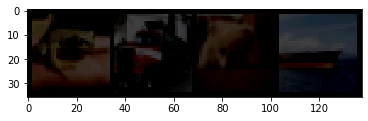

In [7]:
examples = train_loader
samples, labels = iter(examples).next()

print(samples.shape, labels.shape)
print(labels[:4])

imshow(torchvision.utils.make_grid(samples))

## Custom Layers for understanding

In [8]:
conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
print(samples.shape)
x = conv1(samples)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)
# so to pass output flattern [4,16,5,5] -> [4,16*5*5]

torch.Size([4, 3, 32, 32])
torch.Size([4, 6, 28, 28])
torch.Size([4, 6, 14, 14])
torch.Size([4, 16, 10, 10])
torch.Size([4, 16, 5, 5])


## ConvNet Class

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self,x):
        out = self.pool(F.relu(self.conv1(x)))
        out = self.pool(F.relu(self.conv2(out)))
        out = out.view(-1, 16*5*5)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
        

In [10]:
model = ConvNet()

# Num of parameters to train
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

model.to(device)

62006


ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# training loop
n_total_steps = len(train_loader)
for epoch in range(n_epochs):
    for i,(images, labels) in enumerate(train_loader):
        # orig shape: [4, 3, 32, 32] = 4,3,1024
        # input layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%2000 == 0:
            print(f'epoch {epoch+1}/{n_epochs}, steps {i+1}/{n_total_steps}: loss={loss.item():.4f}')
            
print('Finished Training')

epoch 1/4, steps 2000/12500: loss=3.1517
epoch 1/4, steps 4000/12500: loss=1.8386
epoch 1/4, steps 6000/12500: loss=1.3488
epoch 1/4, steps 8000/12500: loss=0.9834
epoch 1/4, steps 10000/12500: loss=0.7266
epoch 1/4, steps 12000/12500: loss=1.1385
epoch 2/4, steps 2000/12500: loss=0.9469
epoch 2/4, steps 4000/12500: loss=1.0396
epoch 2/4, steps 6000/12500: loss=1.3478
epoch 2/4, steps 8000/12500: loss=0.9360
epoch 2/4, steps 10000/12500: loss=0.8196
epoch 2/4, steps 12000/12500: loss=0.5406
epoch 3/4, steps 2000/12500: loss=1.2485
epoch 3/4, steps 4000/12500: loss=1.1608
epoch 3/4, steps 6000/12500: loss=0.8125
epoch 3/4, steps 8000/12500: loss=0.5948
epoch 3/4, steps 10000/12500: loss=1.7245
epoch 3/4, steps 12000/12500: loss=1.8571
epoch 4/4, steps 2000/12500: loss=0.7297
epoch 4/4, steps 4000/12500: loss=1.1982
epoch 4/4, steps 6000/12500: loss=0.7215
epoch 4/4, steps 8000/12500: loss=0.5291
epoch 4/4, steps 10000/12500: loss=0.3200
epoch 4/4, steps 12000/12500: loss=2.4543
Finished

In [13]:
# testing loop
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max return (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}:{acc}%')
    

Accuracy of the network: 55.7 %
Accuracy of plane:41.6%
Accuracy of car:67.1%
Accuracy of bird:53.9%
Accuracy of cat:44.4%
Accuracy of deer:43.7%
Accuracy of dog:18.4%
Accuracy of frog:73.2%
Accuracy of horse:62.1%
Accuracy of ship:85.1%
Accuracy of truck:67.5%
